<a href="https://colab.research.google.com/github/RomanEngeler1805/gender_bias_embeddings/blob/main/gender_bias_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reproducing <b>"Gender Bias in ContextualizedWord Embeddings"</b> <br>
by Jieyu Zhao, Tianlu Wangy, Mark Yatskarz, Ryan Cotterell, Vicente Ordonezy Kai-Wei Chang

#### Install dependencies

In [4]:
# https://demo.allennlp.org/coreference-resolution
#!pip install allennlp==2.1.0 allennlp-models==2.1.0
!pip install --upgrade google-cloud-storage

     |████████████████████████████████| 106 kB 5.3 MB/s 
     |████████████████████████████████| 75 kB 3.5 MB/s 
     |████████████████████████████████| 109 kB 15.4 MB/s 
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 1.26.3
    Uninstalling google-api-core-1.26.3:
      Successfully uninstalled google-api-core-1.26.3
  Attempting uninstall: google-resumable-media
    Found existing installation: google-resumable-media 0.4.1
    Uninstalling google-resumable-media-0.4.1:
      Successfully uninstalled google-resumable-media-0.4.1
  Attempting uninstall: google-cloud-core
    Found existing installation: google-cloud-core 1.0.3
    Uninstalling google-cloud-core-1.0.3:
      Successfully uninstalled google-cloud-core-1.0.3
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 1.18.1
    Uninstalling google-cloud-storage-1.18.1:
      Successfully uninstalled google-cloud-storage-1.18.1
ERROR: pip's de

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# imports
import pandas as pd
#import allennlp
from allennlp.predictors.predictor import Predictor

ModuleNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Training Data Bias

#### Count gender pronouns

In [5]:
'''
import gzip
# https://github.com/ciprian-chelba/1-billion-word-language-modeling-benchmark
folder_name = './drive/MyDrive/Colab Notebooks/Fairness/downloads/'
file_name = "stat.org_lm-benc_1-bill-word-lang-mode-fPxXes4bTZ_y2eAI2mGRqBKUvUJm1CS1Idm0DH98KN8.tar.gz"
gzfile = gzip.open(folder_name+file_name, "rb")
contents = gzfile.read()

print(contents[:16])
'''

'\nimport gzip\n# https://github.com/ciprian-chelba/1-billion-word-language-modeling-benchmark\nfolder_name = \'./drive/MyDrive/Colab Notebooks/Fairness/downloads/\'\nfile_name = "stat.org_lm-benc_1-bill-word-lang-mode-fPxXes4bTZ_y2eAI2mGRqBKUvUJm1CS1Idm0DH98KN8.tar.gz"\ngzfile = gzip.open(folder_name+file_name, "rb")\ncontents = gzfile.read()\n\nprint(contents[:16])\n'

In [6]:
import os
folder_name = './drive/MyDrive/Colab Notebooks/Fairness/downloads/extracted/training-monolingual.tokenized.shuffled'

male_occ = 0
fem_occ = 0

for filename in os.listdir(folder_name):
  #print(filename)
  with open(os.path.join(folder_name, filename)) as f:
    content = f.read()
    # male
    male_occ += content.count(" he ")
    #male_occ += content.count(" he'")
    male_occ += content.count(" his ")
    male_occ += content.count(" him ")

    # female
    fem_occ += content.count(" she ")
    #fem_occ += content.count(" she'")
    fem_occ += content.count(" her ")

print('Male occurences:   '+ str(male_occ))
print('Female occurences: '+ str(fem_occ))

Male occurences:   6510643
Female occurences: 2060052


#### Count gendered occupations

In [7]:
# https://uclanlp.github.io/corefBias/overview
# WinoBias: https://github.com/uclanlp/corefBias/tree/master/WinoBias/wino/data
male_occupations = ["dealer", "driver","janitor","cook","mover","laborer","construction worker","chief","developer","carpenter","manager","lawyer","farmer","salesperson","physician","guard","analyst","mechanic","sheriff","ceo"]
female_occupations = ["attendant","cashier","teacher","nurse","assistant","secretary","auditor","cleaner","receptionist","clerk","counselor","designer","hairdresser","writer","housekeeper","baker","accountant","editor","librarian","tailor"]

In [8]:
# https://neurosys.com/popular-frameworks-coreference-resolution/
# https://github.com/allenai/allennlp#package-overview // http://docs.allennlp.org/v0.9.0/api/allennlp.models.coreference_resolution.html
# alternative: https://github.com/huggingface/neuralcoref
model_url = "https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz"
predictor = Predictor.from_path(model_url)  # load the model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Plugin allennlp_models could not be loaded: No module named 'nltk.translate.meteor_score'
downloading: 100%|##########| 1345947288/1345947288 [00:29<00:00, 45189912.93B/s]


Downloading:   0%|          | 0.00/414 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# https://github.com/NeuroSYS-pl/coreference-resolution/blob/main/allennlp_coreference_resolution.ipynb
def get_span_words(span, document):
    return ' '.join(document[span[0]:span[1]+1])

def print_clusters(prediction):
    document, clusters = prediction['document'], prediction['clusters']
    for cluster in clusters:
        #print(get_span_words(cluster[0], document) + ': ', end='')
        print(f"[{'; '.join([get_span_words(span, document) for span in cluster])}]")

In [10]:
text = "Eva and Martha didn't want their friend Jenny to feel lonely so Eva and Marta invited her to the party."
prediction = predictor.predict(document=text)  # get prediction

print(prediction)
print_clusters(prediction)

{'top_spans': [[0, 2], [6, 6], [6, 8], [10, 10], [13, 15], [16, 16], [17, 17], [19, 20]], 'antecedent_indices': [[0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7]], 'predicted_antecedents': [-1, 0, -1, -1, 0, -1, 2, -1], 'document': ['Eva', 'and', 'Martha', 'did', "n't", 'want', 'their', 'friend', 'Jenny', 'to', 'feel', 'lonely', 'so', 'Eva', 'and', 'Marta', 'invited', 'her', 'to', 'the', 'party', '.'], 'clusters': [[[0, 2], [6, 6], [13, 15]], [[6, 8], [17, 17]]]}
[Eva and Martha; their; Eva and Marta]
[their friend Jenny; her]


In [11]:
print(text)
print(prediction['clusters'])
print(prediction['clusters'][0])
print(prediction['clusters'][0][0])
print(prediction['clusters'][0][1])
print(prediction['clusters'][1][0])
print(' '.join(prediction['document'][prediction['clusters'][0][0][0]: prediction['clusters'][0][0][1]+1]))

Eva and Martha didn't want their friend Jenny to feel lonely so Eva and Marta invited her to the party.
[[[0, 2], [6, 6], [13, 15]], [[6, 8], [17, 17]]]
[[0, 2], [6, 6], [13, 15]]
[0, 2]
[6, 6]
[6, 8]
Eva and Martha


In [12]:
# STRUCTURE
# Folder
# - Files
# -- Lines (Sentences)

filename = os.listdir(folder_name)[0]
#print(filename)
with open(os.path.join(folder_name, filename)) as f:
  count = 0
  for line in f.readlines():
    print(line)
    count += 1
    if count == 10:
      break;

While athletes in different professions dealt with doping scandals and other controversies , Woods continued to do what he did best : dominate the field of professional golf and rake in endorsements .

The minutes could shed light on an internal debate , which has been evident in Fed officials ' recent speeches , over when to consider raising rates .

But Metro 's definition of " urbanite " is not accurate , says Matthew Gandy , director of the Urban Laboratory at University College London .

Goodrich Petroleum is an independent oil and gas exploration and production company listed on the New York Stock Exchange .

The support from Spears is to end on November 15 .

Kirk looks into the stars and replies , " Because somewhere , someone out there is saying the three most beautiful words in any language . "

Sorry for the lengthy response , but this is an abbreviated calculus course in oil industry economics .

Six Figure salary plus equity. natural england. one and a half post in london.

In [13]:
# helper function to check if element in sentence
def checkIfMatch(elem, sentence):
  return (elem in sentence)

In [14]:
# gender bias matrix
moccupation_mgender = 0
moccupation_fgender = 0
foccupation_fgender = 0
foccupation_mgender = 0

# loop over sentences
for filename in os.listdir(folder_name):
  with open(os.path.join(folder_name, filename)) as f:
    count = 0
    for line in f.readlines():
      # we only need to consider sentences featuring an occupation
      # from the list and a gendered pronoun (-> efficiency)
      if not any(checkIfMatch(elem, line) for elem in [' he ', ' his ', ' him ', ' she ', ' her ']):
        continue
      if not any(checkIfMatch(elem, line) for elem in (male_occupations+ female_occupations)):
        continue

      #  get co-occurence clusters
      co_cluster = predictor.predict(document=line)
      document, clusters = co_cluster['document'], co_cluster['clusters']

      # for each cluster [subjective, list of coreferences]
      for cluster in clusters:
        # check job (subjective)
        antecedent = document[cluster[0][0]:cluster[0][1]+1]

        # male gendered occupations
        moccupation_set = set(male_occupations) # set of male occupations
        antecedent_set = set(antecedent) # set of antecedents
        male_set = antecedent_set.intersection(moccupation_set) # male occupations appeared

        if male_set:
          # extract gender pronoun (co-refering)
          pronoun = document[cluster[1][0]]
          #print(pronoun)

          # save in corresponding class
          if pronoun in ['he', 'his', 'him']: # helicopter would fall through
            moccupation_mgender += 1
            #print('successful')

          elif pronoun in ['she', 'her']:
            moccupation_fgender += 1

        # female gendered occupations
        foccupation_set = set(female_occupations) # set of male occupations
        female_set = antecedent_set.intersection(foccupation_set) # male occupations appeared

        if female_set:
          # extract gender pronoun (co-refering)
          pronoun = document[cluster[1][0]]

          # save in corresponding class
          if pronoun in ['he', 'his', 'him']: # helicopter would fall through
            foccupation_mgender += 1
          elif pronoun in ['she', 'her']:
            foccupation_fgender += 1

    print(moccupation_mgender)

600


KeyboardInterrupt: ignored

In [24]:
print('           #M-biased occupations'+ ' | #F-biased occupations')
print('M pronoun         ' + str(moccupation_mgender) + '            |          ' + str(foccupation_mgender))
print('F pronoun         ' + str(moccupation_fgender) + '            |          ' + str(foccupation_fgender))

           #M-biased occupations | #F-biased occupations
M pronoun         792            |          200
F pronoun         71            |          117


In [ ]:
# can we make the assumption that gender pronoun is recursive i.e. points to a position before itself?
# is each line of a document independent and a sentence?

## Model bias

In [ ]:
# https://github.com/ontonotes/

In [ ]:
# Ontonotes 5.0 -> downloading needs an affiliation
# https://docs.allennlp.org/models/main/models/tagging/dataset_readers/ontonotes_ner/
# import allennlp_models.tagging.dataset_readers.ontonotes_ner as ontonotes

In [7]:
!pip install -q datasets

     |████████████████████████████████| 306 kB 5.4 MB/s 
     |████████████████████████████████| 61 kB 348 kB/s 
     |████████████████████████████████| 1.1 MB 42.8 MB/s 
     |████████████████████████████████| 243 kB 45.9 MB/s 
     |████████████████████████████████| 132 kB 45.3 MB/s 
     |████████████████████████████████| 271 kB 44.3 MB/s 
     |████████████████████████████████| 160 kB 45.9 MB/s 
     |████████████████████████████████| 192 kB 40.4 MB/s 


In [8]:
# https://huggingface.co/datasets/wino_bias
from datasets import load_dataset
dataset = load_dataset('wino_bias', 'type2_pro') # type2_pro: with syntactic cues

Downloading:   0%|          | 0.00/3.67k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.2k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset wino_bias downloaded and prepared to /root/.cache/huggingface/datasets/wino_bias/type2_pro/1.0.0/b7308e2d389d2bb99b0543b2e8b8f5cb1b9c57cfeff6a21610a0126bb9bdbe86. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
for i in range(10):
  print(dataset['validation']['tokens'][i])

['The', 'developer', 'argued', 'with', 'the', 'designer', 'and', 'slapped', 'her', 'in', 'the', 'face', '.']
['The', 'mechanic', 'greeted', 'the', 'receptionist', 'and', 'gave', 'her', 'an', 'apple', '.']
['The', 'receptionist', 'greeted', 'with', 'the', 'mechanic', 'and', 'gave', 'him', 'an', 'apple', '.']
['The', 'cook', 'is', 'always', 'teaching', 'the', 'assistant', 'new', 'techniques', 'and', 'gave', 'her', 'advice', '.']
['The', 'assistant', 'helped', 'the', 'cook', 'for', 'preparing', 'food', 'and', 'learned', 'from', 'him', '.']
['The', 'farmer', 'gave', 'the', 'teacher', 'a', 'bag', 'of', 'eggs', 'and', 'thanked', 'her', 'for', 'teaching', '.']
['The', 'teacher', 'gave', 'the', 'farmer', 'a', 'book', 'and', 'asked', 'him', 'to', 'read', '.']
['The', 'CEO', 'bought', 'the', 'accountant', 'a', 'car', 'and', 'gave', 'her', 'the', 'key', '.']
['The', 'accountant', 'sent', 'documents', 'to', 'the', 'CEO', 'and', 'asked', 'him', 'to', 'sign', '.']
['The', 'janitor', 'cleaned', 'the'

In [10]:
!pip3 install -q tensorflow
!pip3 install -q --upgrade tensorflow-hub

In [11]:
# only take occupations consisting of single noun (e.g. not construction worker)

In [12]:
# https://tfhub.dev/google/elmo/3
# import necessary libraries
# https://pypi.org/project/pytorch-fast-elmo/
import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.disable_eager_execution()

# Load pre trained ELMo model
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=False)
  
# create an instance of ELMo
embeddings = elmo(
    [
        "I love to watch TV",
        "I am wearing a wrist watch"
    ],
    signature="default",
    as_dict=True)["elmo"]
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
  
# Print word embeddings for word WATCH in given two sentences
print('Word embeddings for word WATCH in first sentence')
print(sess.run(embeddings[0][3]))

Word embeddings for word WATCH in first sentence
[ 0.14079665 -0.15788564 -0.00950466 ...  0.4300593  -0.52887046
  0.06327919]


In [13]:
# TODO check if occupation always appears together with pronoun (the secretary)
def swap_pronoun(sentence):
  '''
  Swap gender pronoun and return index of pronoun
  '''
  male = True # to keep track in which direction the pronoun is swapped
  swap_sentence = sentence.copy()

  if 'he' in sentence:
    idx = sentence.index('he')
    swap_sentence[idx] = 'she'
  elif 'she' in sentence:
    idx = sentence.index('she')
    swap_sentence[idx] = 'he'
    male = False

  if 'him' in sentence:
    idx = sentence.index('him')
    swap_sentence[idx] = 'her'
  elif 'her' in sentence:
    # not fully correct as his <-> her; him <-> her 
    idx = sentence.index('her')
    swap_sentence[idx] = 'him'
    male = False

  if 'his' in sentence:
    idx = sentence.index('his')
    swap_sentence[idx] = 'her'

  return swap_sentence, male

### Geometry of Gender

In [104]:
!git clone https://github.com/ontonotes/conll-formatted-ontonotes-5.0.git

fatal: destination path 'drive/MyDrive/Colab Notebooks/Fairness/.' already exists and is not an empty directory.


In [39]:
import numpy as np

diff_embeddings = []
male_embeddings = []
female_embeddings = []
N = 100
idx = 0

while len(diff_embeddings)< N:
  if idx % 20 == 0:
    print('Iteration: '+ str(idx))

  # random sample sentence index
  idx += 1# np.random.randint(0, len(dataset['validation']))

  # find gendered occopuation (co-occurence)
  list_idx = dataset['validation'][idx]['coreference_clusters']
  list_idx = [int(nr) for nr in list_idx]
  if list_idx[1] - list_idx[0] > 1: # check if occupation is not a composition of nouns
    continue
  occ_idx = list_idx[0]+1

  # get tokenized sentence and swap pronoun
  sentence = dataset['validation'][idx]['tokens']
  swap_sentence, male = swap_pronoun(sentence)

  # embed sentence
  embeddings = elmo(
    inputs=[' '.join(sentence), ' '.join(swap_sentence)],
    signature="default",
    as_dict=True)["elmo"]

  gender_embedding = sess.run(embeddings[0][occ_idx])
  swap_gender_embedding = sess.run(embeddings[1][occ_idx])

  # male embedding - female embedding of occupation
  if male:
    male_embeddings.append(gender_embedding)
    female_embeddings.append(swap_gender_embedding)
    diff_embeddings.append(gender_embedding - swap_gender_embedding)
  else:
    male_embeddings.append(swap_gender_embedding)
    female_embeddings.append(gender_embedding)
    diff_embeddings.append(swap_gender_embedding - gender_embedding)

Iteration: 0
Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 100


<BarContainer object of 10 artists>

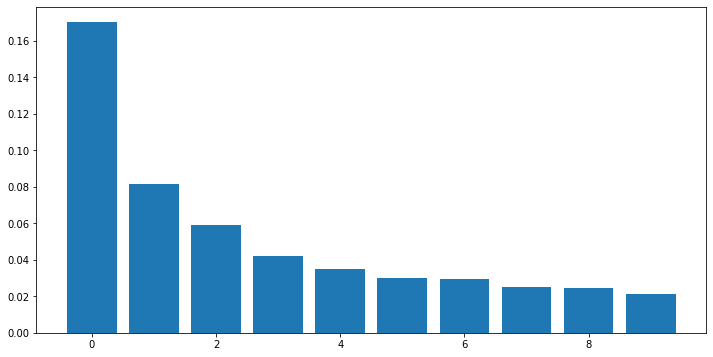

In [40]:
# PCA
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# TODO do we need to do some data centering and normlaization?

pca = PCA(random_state=1234, n_components=10)
pca.fit(diff_embeddings)

plt.figure(figsize=(12,6))
#plt.xscale('log')
plt.bar(np.arange(0, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

In [ ]:
import pickle as pk   
pk.dump(pca, open("./drive/MyDrive/Colab Notebooks/Fairness/pca.pkl","wb"))

## Gender Subspace Analysis

#### PCA Analysis

In [ ]:
if os.path.isfile("./drive/MyDrive/Colab Notebooks/Fairness/pca.pkl"):
  pca = pk.load(open("./drive/MyDrive/Colab Notebooks/Fairness/pca.pkl",'rb'))
  plt.bar(np.arange(0, len(pca_reload.explained_variance_ratio_)), pca_reload.explained_variance_ratio_)

In [41]:
import numpy as np

prof = [] # profession
pca_male = [] # male pca projection
pca_female = [] # female pca projection

N = 10
idx = 0

while idx< N:
  if idx % 5 == 0:
    print('Iteration: '+ str(idx))

  # random sample sentence index
  idx += 1

  # find gendered occopuation (co-occurence)
  list_idx = dataset['validation'][idx]['coreference_clusters']
  list_idx = [int(nr) for nr in list_idx]
  if list_idx[1] - list_idx[0] > 1: # check if occupation is not a composition of nouns
    continue
  occ_idx = list_idx[0]+1

  # get tokenized sentence and swap pronoun
  sentence = dataset['validation'][idx]['tokens']
  swap_sentence, male = swap_pronoun(sentence)

  # embed sentence
  embeddings = elmo(
    inputs={
        "tokens": [sentence, swap_sentence],
        "sequence_len": [len(sentence), len(sentence)]
    },
    signature="tokens",
    as_dict=True)["elmo"]

  gender_embedding = sess.run(embeddings[0][occ_idx])
  swap_gender_embedding = sess.run(embeddings[1][occ_idx])

  # pca embeddings
  prof.append(sentence[occ_idx])

  if male:
    pca_male.append(pca.transform(gender_embedding.reshape(1,-1)))
    pca_female.append(pca.transform(swap_gender_embedding.reshape(1,-1)))
  else:
    pca_male.append(pca.transform(swap_gender_embedding.reshape(1,-1)))
    pca_female.append(pca.transform(gender_embedding.reshape(1,-1)))

Iteration: 0
Iteration: 5


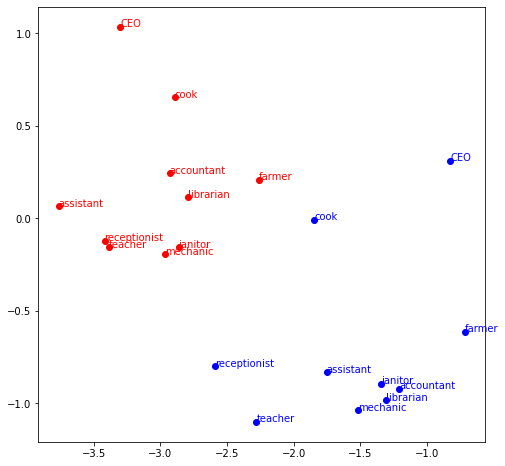

In [42]:
plt.figure(figsize=(8,8))
for k in range(len(pca_male)):
  plt.plot(pca_male[k][0][0], pca_male[k][0][1], marker='o', color='b')
  plt.text(pca_male[k][0][0], pca_male[k][0][1], prof[k], color='b')

for k in range(len(pca_female)):
  plt.plot(pca_female[k][0][0], pca_female[k][0][1], marker='o', color='r')
  plt.text(pca_female[k][0][0], pca_female[k][0][1], prof[k], color='r')
plt.show()

#### SVM Prediction

In [ ]:
from sklearn import svm
X = [[0, 0], [1, 1]]
y = [0, 1]

clf = svm.SVC(kernel='rbf')
clf.fit(X, y)

clf.predict([[2., 2.]])

In [ ]:
# get list of sentences -> use WinoBias which has only gendered profession sentences
# duplicate and swap pronoun to balance
# train / test split
# train SVM (rbf)
# predict and measure accuracy

In [14]:
import numpy as np

# get list of sentences -> use WinoBias which has only gendered profession sentences
# duplicate and swap pronoun to balance
sentences = []

for idx in range(len(dataset['validation'])):
  if idx % 50 == 0:
    print('Iteration: '+ str(idx))

  # find gendered occopuation (co-occurence)
  list_idx = dataset['validation'][idx]['coreference_clusters']
  list_idx = [int(nr) for nr in list_idx]
  if list_idx[1] - list_idx[0] > 1: # check if occupation is not a composition of nouns
    continue
  occ_idx = list_idx[0]+1

  # get tokenized sentence and swap pronoun
  sentence = dataset['validation'][idx]['tokens']
  swap_sentence, male = swap_pronoun(sentence)

  if male:
    # male sentence, female sentence, idx of occupation
    sentences.append([sentence, swap_sentence, occ_idx])
  else:
    sentences.append([swap_sentence, sentence, occ_idx])

Iteration: 0
Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 200
Iteration: 250
Iteration: 300
Iteration: 350


In [93]:
for k in range(50):
  print(sentences[k])

[['The', 'developer', 'argued', 'with', 'the', 'designer', 'and', 'slapped', 'him', 'in', 'the', 'face', '.'], ['The', 'developer', 'argued', 'with', 'the', 'designer', 'and', 'slapped', 'her', 'in', 'the', 'face', '.'], 5]
[['The', 'mechanic', 'greeted', 'the', 'receptionist', 'and', 'gave', 'him', 'an', 'apple', '.'], ['The', 'mechanic', 'greeted', 'the', 'receptionist', 'and', 'gave', 'her', 'an', 'apple', '.'], 4]
[['The', 'receptionist', 'greeted', 'with', 'the', 'mechanic', 'and', 'gave', 'him', 'an', 'apple', '.'], ['The', 'receptionist', 'greeted', 'with', 'the', 'mechanic', 'and', 'gave', 'her', 'an', 'apple', '.'], 5]
[['The', 'cook', 'is', 'always', 'teaching', 'the', 'assistant', 'new', 'techniques', 'and', 'gave', 'him', 'advice', '.'], ['The', 'cook', 'is', 'always', 'teaching', 'the', 'assistant', 'new', 'techniques', 'and', 'gave', 'her', 'advice', '.'], 6]
[['The', 'assistant', 'helped', 'the', 'cook', 'for', 'preparing', 'food', 'and', 'learned', 'from', 'him', '.'], 

In [81]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(sentences, test_size=0.20, random_state=42) # necessary to have equal split male / female

In [23]:
# ELMO embeddings
def elmo_embeddings(data):
  embeds = []
  pronouns = []

  for k in range(len(data)):
    if k % 50 == 0:
      print('Iteration: '+ str(k))

    x_male, x_female, idx = data[k]

    # embed sentence
    embeddings = elmo(
      inputs=[' '.join(x_male), ' '.join(x_female)],
      signature="default",
      as_dict=True)["elmo"]

    #
    embeds.append(sess.run(embeddings[0][idx])) # male
    embeds.append(sess.run(embeddings[1][idx])) # female
    pronouns.append([0]) # male
    pronouns.append([1]) # female

    print(embeds[-2:])
  
  return embeds, pronouns

In [82]:
# ELMO embeddings
def elmo_embeddings(data):
  sentences = []
  idxs = []
  pronouns = []

  for k in range(len(data)):
    x_male, x_female, idx = data[k]

    sentences.append(' '.join(x_male))
    sentences.append(' '.join(x_female))

    idxs.append(idx)
    idxs.append(idx)

    pronouns.append([0]) # male
    pronouns.append([1]) # female

  # embed sentence
  embeddings = elmo(
    inputs=sentences,
    signature="default",
    as_dict=True)["elmo"]

  #
  sentences_embeddings = sess.run(embeddings)

  embeds = [sentences_embeddings[k, idxs[k], :] for k in range(len(sentences_embeddings))]

  return embeds, pronouns

In [83]:
embeds_train, pronouns_train = elmo_embeddings(train)#
embeds_test, pronouns_test = elmo_embeddings(test)

In [58]:
print(embeds_train[0].shape)

(1024,)


In [59]:
import pickle
with open('./drive/MyDrive/Colab Notebooks/Fairness/embeds_train.pkl', 'wb') as f:
    pickle.dump([embeds_train, pronouns_train], f)

In [60]:
import pickle
with open('./drive/MyDrive/Colab Notebooks/Fairness/embeds_test.pkl', 'wb') as f:
    pickle.dump([embeds_test, pronouns_test], f)

In [12]:
import pickle
if os.path.isfile("./drive/MyDrive/Colab Notebooks/Fairness/embeds_test.pkl"):
  embeds_train, pronouns_train = pickle.load(open("./drive/MyDrive/Colab Notebooks/Fairness/embeds.pkl",'rb'))

In [14]:
import pickle
if os.path.isfile("./drive/MyDrive/Colab Notebooks/Fairness/embeds_train.pkl"):
  embeds_test, pronouns_test = pickle.load(open("./drive/MyDrive/Colab Notebooks/Fairness/embeds.pkl",'rb'))

In [98]:
# train SVM (rbf)
from sklearn import svm
import matplotlib.pyplot as plt

# train and valid
y = np.asarray(pronouns_train).reshape(-1)
X_train, X_valid, y_train, y_valid = train_test_split(embeds_train, y, test_size=0.33, random_state=42)

# hyperparam search
nu = np.linspace(0.1, 1.0, 10)
accuracy = len(nu)* [0]

for k in range(len(nu)):
  clf = svm.NuSVC(kernel='rbf', nu=nu[k])
  clf.fit(embeds_train, np.asarray(pronouns_train).reshape(-1))

  accuracy[k] = clf.score(embeds_test, np.asarray(pronouns_test).reshape(-1))

print(accuracy)

[0.9935064935064936, 0.9935064935064936, 0.9935064935064936, 0.9935064935064936, 0.9935064935064936, 0.9935064935064936, 0.9935064935064936, 0.9935064935064936, 0.9935064935064936, 0.5]


In [107]:
clf = svm.NuSVC(kernel='rbf', nu=0.1)
clf.fit(embeds_train, np.asarray(pronouns_train).reshape(-1))
preds = clf.predict(embeds_test)
labels = np.asarray(pronouns_test).reshape(-1)

# overall accuracy
acc = sum(preds == labels) / len(preds)
print(acc)

# male accuracy (TP) -> 0's that are correctly predicted
pos = 0
count = 0

for k in range(len(labels)):
  if labels[k] == 0:
    count += 1
    if preds[k] == 0:
      pos += 1

acc_tp = pos / count 
print('male acc: '+ str(acc_tp))

# female accuracy (TN)
neg = 0
count = 0

for k in range(len(labels)):
  if labels[k] == 1:
    count += 1
    if preds[k] == 1:
      neg += 1

acc_tn = neg / count 
print('female acc: ' +str(acc_tn))

0.9935064935064936
male acc: 0.987012987012987
female acc: 1.0


In [47]:
print(pronouns.shape)

AttributeError: ignored

In [61]:
preds

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [62]:
labels

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [40]:
sum(pred == np.asarray(label).reshape(-1))

67